[View in Colaboratory](https://colab.research.google.com/github/rrcarlson/Intro_python_geo/blob/master/Intro_Python_geospatial.ipynb)

## Session Prep

In [0]:
#@title
# Install OpticalRS. This also installs GeoPandas because GeoPandas is a dependency of OpticalRS
!apt-get install software-properties-common python-software-properties > /dev/null
!add-apt-repository ppa:ubuntugis/ppa -y > /dev/null
!apt-get update > /dev/null
!apt-get install -y --fix-missing python-gdal gdal-bin libgdal-dev > /dev/null
!pip2 install OpticalRS > /dev/null

gpg: keybox '/tmp/tmpwhaygiog/pubring.gpg' created
gpg: /tmp/tmpwhaygiog/trustdb.gpg: trustdb created
gpg: key 089EBE08314DF160: public key "Launchpad ubuntugis-stable" imported
gpg: Total number processed: 1
gpg:               imported: 1
E: The repository 'http://ppa.launchpad.net/ubuntugis/ppa/ubuntu artful Release' does not have a Release file.


# Intro to Python

![Python image](https://github.com/rrcarlson/Intro_python_geo/blob/master/images/python.jpg?raw=1)

Python is a rich, versatile language with lots of prolific contributors. So where to start? 

For reference, below are some Python tutorials that cover a range of Python libraries. We won't spend too much time today on basic syntax, etc., since that's well covered elsewhere and kinda boring. As a Python newbie, I've found that using Pandas/GeoPandas and NumPy have introduced me organically to other libraries, and have allowed me to see results quickly for basic geospatial tasks--so we'll start there!
* [Python basics](https://github.com/sinkovit/PythonSeries/blob/master/Python%20basics.ipynb): How to create lists, dictionaries, iterators, etc.
* [Python Markdown and LaTex](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet): Documentation and formatting
* Matplotlib: Data visualization
* [Pandas](https://pandas.pydata.org/pandas-docs/stable/10min.html): Data wrangling and preparation using two types of data objects: 1) DataFrames, 2) Series.
* [GeoPandas](https://automating-gis-processes.github.io/2016/Lesson2-overview-pandas-geopandas.html): Basically the geospatial version of Pandas. Adds geospatial functionality to the DataFrame (Geo + DataFrame = GeoDataFrame).
* [NumPy](https://www.datacamp.com/community/tutorials/python-numpy-tutorial): Multi-dimensional data arrays for manipulating large datasets. There are some functions for linear algebra and statistics within NumPy but it's also used by SciPy, matplotlib, and pandas for scientific computing.
* [SciPy](http://www.randalolson.com/2012/08/06/statistical-analysis-made-easy-in-python/): Scientific computing and statistical analysis. Uses NumPy, Matplotlib, and Pandas, and is common in earth sciences, astronomy, and oceanography.
* [Shapely](http://toblerity.org/shapely/manual.html): Spatial data model for planar features (points, curves, and surfaces).
* Skikit-learn: regression, clustering, and classification algorithms
* Various [cool tricks](https://community.modeanalytics.com/python/)

# Conservation in the Dominican Republic

![Reef image](https://github.com/rrcarlson/Intro_python_geo/blob/master/images/01_coral_reef_bright_spot.jpg?raw=1)

In this tutorial, we'll be testing out two Python libraries, **GeoPandas** and **NumPy**, that are useful in GIS. Our objectives: to filter and analyze vector and raster data for conservation areas in the Dominican Republic.

We'll use two datasets:
* **Conservation Areas of the Dominican Republic**: Vector data delineating conservation area boundaries, from the [World Database of Protected Areas (WDPA)](https://www.iucn.org/theme/protected-areas/our-work/world-database-protected-areas).
* **Gridded Bathymetric Data**: Raster data (30 arc-second resolution) on bathymetry from the [British Oceanographic Data Center](https://www.bodc.ac.uk/data/hosted_data_systems/gebco_gridded_bathymetry_data/).

Our goals are:
* **Filter the WDPA database** to find only conservation areas for the marine environment (Marine Protected Areas)
* **Clip rasters** to MPA boundaries
* **Analyze raster data** (bathymetry) within Marine Protected Area boundaries to find
    * Mean depth per MPA
    * Standard deviation of depth per MPA
    * Range of depth per MPA

# Step 1: Load your libraries

What modules do we need?
* Vector data comes in a tabular format, with one geometric feature per row. So we need a library to organize geographic data in a DataFrame.
**That's Pandas** (more specifically, **GeoPandas**).
* Raster data is a little trickier. It comes to us in a grid of pixel values, sometimes in multiple bands (3+ dimensions). We need a library to organize arrays/matrices of values in *n* dimensions. **That's NumPy**.
* Numpy isn't explicitly designed to handle raster data. We need the help of another library to convert our raster files into array format. **That's [OpticalRS](https://github.com/jkibele/OpticalRS)**, created by NCEAS' very own Jared Kibele! OpticalRS borrows a bit of code from [an old version of rasterstats](https://github.com/perrygeo/python-rasterstats/releases/tag/0.5) to do the actual raster subsetting.
* We'll want to plot stuff, so we need a library for data visualization. That's **matplotlib**.

![arrays image](https://github.com/rrcarlson/Intro_python_geo/blob/master/images/arrays.png?raw=1)

In [0]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib
from OpticalRS import *

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Step 2: Prep your vector data

## Step 2.1 Read in your vector data: GeoPandas

Reading in tabular data is pretty simple. Just remember:
* DataFrame = Pandas = `pd.read_csv()`
* GeoDataFrame = DataFrame with geometry attribute = GeoPandas = `gpd.read_file()`

In [0]:
# Loading my local files into Colaboratory
from google.colab import files
uploaded = files.upload()

Saving WDPA_polygons.cpg to WDPA_polygons (1).cpg
Saving WDPA_polygons.dbf to WDPA_polygons (1).dbf
Saving WDPA_polygons.prj to WDPA_polygons (1).prj
Saving WDPA_polygons.shp to WDPA_polygons (1).shp
Saving WDPA_polygons.shx to WDPA_polygons (1).shx


In [0]:
# Define your vector filepath
conserve_fp = "WDPA_polygons.shp"

# Read vector data in as GeoDataFrame
conserve = gpd.read_file(conserve_fp)

Our first preprocessing step is to check on the data's projection. Projections can be tricky and I'm not going to delve too far into this topic here, but below are some basic steps for identifying and changing your data's projection (more details can be found [here](http://geopandas.org/projections.html)).

In [0]:
# Check the Coordinate Reference System (CRS)
conserve.crs

{'init': u'epsg:4326'}

In [0]:
# Change your CRS, for fun. Then change it back (because we like EPSG = 4326).
conserve = conserve.to_crs(epsg=3857)
conserve = conserve.to_crs(epsg=4326)

### Exercise 2.1

In [0]:
# Read in your WDPA shapefile as a GeoDataFrame.

# Check the projection of your data.

## Step 2.2 Explore your vector data: GeoPandas

We can use some basic exploratory functions in GeoPandas to query our data.

In [0]:
# Look at all of the attributes in your dataset
conserve.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 29 columns):
WDPAID        143 non-null float64
WDPA_PID      143 non-null object
PA_DEF        143 non-null object
NAME          143 non-null object
ORIG_NAME     143 non-null object
DESIG         143 non-null object
DESIG_ENG     143 non-null object
DESIG_TYPE    143 non-null object
IUCN_CAT      143 non-null object
INT_CRIT      143 non-null object
MARINE        143 non-null object
REP_M_AREA    143 non-null float64
GIS_M_AREA    143 non-null float64
REP_AREA      143 non-null float64
GIS_AREA      143 non-null float64
NO_TAKE       143 non-null object
NO_TK_AREA    143 non-null float64
STATUS        143 non-null object
STATUS_YR     143 non-null int64
GOV_TYPE      143 non-null object
OWN_TYPE      143 non-null object
MANG_AUTH     143 non-null object
MANG_PLAN     143 non-null object
VERIF         143 non-null object
METADATAID    143 non-null int64
SUB_LOC       143 non-null object

There are 143 data objects with 29 attributes, of various data types (object, float, integer). In the pandas world, data types break down like this:
* dtype('O') = object = string
* dtype('int64') = integer
* dtype('float64') = float

More precise info on data types [here](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html#)

In [0]:
# What is the total conserved area in the DR? Conserved area = "GIS_AREA" (we'll discuss how to use the inherent geometry of the GeoDataFrame to do this later).
area_sum = conserve.GIS_AREA.sum()
area_sum

65255.47670531727

In [0]:
# What is the largest area conserved?
area_max = conserve.GIS_AREA.max()
area_max

35469.1970057065

In [0]:
# What is the smallest area conserved?
area_min = conserve.GIS_AREA.min()
area_min

0.007879848064912

In [0]:
# What are the unique values for the "MARINE" attribute?
conserve['MARINE'].unique()

array([u'2', u'1', u'0'], dtype=object)

In [0]:
# How many different areas are "Marine" (2), "Terrestrial" (0), or both (1)?
type_park = conserve['MARINE'].value_counts()
type_park

0    109
1     27
2      7
Name: MARINE, dtype: int64

In [0]:
# Write all of this info into a string
"The total conserved area is {} square meters and there are {} MPAs, {} terrestrial areas, and {} mixed areas".format(area_sum, type_park["2"], type_park["0"], type_park["1"])

'The total conserved area is 65255.4767053 square meters and there are 7 MPAs, 109 terrestrial areas, and 27 mixed areas'

### Exercise 2.2

In [0]:
# What are the options for park designation in English ("DESIG_ENG")?


In [0]:
# How many different areas are designated as "Wildlife Refuge"?


For a complete list of methods available for exploring GeoDataFrames, see [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html).

## Step 2.3 Plot your vector data: GeoPandas

GeoPandas offers some basic plotting methods for quick visualization. You can create more advanced plots (with customizable layering, formatting) using the Matplotlib library. Matplotlib can be a bit confusing at first, so here's a [great tutorial](https://github.com/matplotlib/AnatomyOfMatplotlib/blob/master/AnatomyOfMatplotlib-Part1-Figures_Subplots_and_layouts.ipynb) if you want to learn more. As in R, you can also create interactive maps through [Leaflet](https://automating-gis-processes.github.io/2016/Lesson5-interactive-map-folium.html) and [Bokeh](https://automating-gis-processes.github.io/2016/Lesson5-interactive-map-bokeh.html).

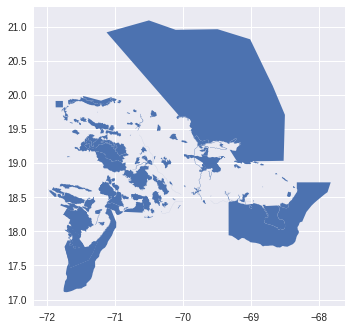

In [0]:
# Plot conservation areas
conserve.plot()

In [0]:
# Plot conservation areas as choropleth by park type
conserve.plot(column = "DESIG_ENG", cmap = "Paired")

In [0]:
# Make it red! Color palettes: https://matplotlib.org/users/colormaps.html
conserve.plot(column = "DESIG_ENG", cmap = "hot")

In [0]:
# Plot conservation areas where the area has a Use Management Plan.
conserve[conserve['MANG_PLAN'] != "No"].plot()

### Exercise 2.3

In [0]:
# Plot conservation areas as a choropleth by the "MARINE" attribute
conserve.plot(column = "MARINE")

In [0]:
# Make it blue (obviously)! https://matplotlib.org/users/colormaps.html
conserve.plot(column = 'MARINE', cmap="Blues")

## Step 2.4 Filter your vector data: GeoPandas

**Looking above at our "To Do" list, our first task was this:** "Filter the WDPA database to find only conservation areas for the marine environment (Marine Protected Areas)."

In R-speak, we're using Python to `dplyr::filter`. To subset data in Python, we use the `loc` and `iloc` indexing tools. Documentation can be found [here](http://pandas.pydata.org/pandas-docs/version/0.17/generated/pandas.DataFrame.drop_duplicates.html) under "Indexing and Selecting Data" (basically the Python version of R's Data Wrangling cheat sheet).

The basics are this:
* `iloc` selects data on a known index (integer value). Example: `iris.iloc[7]` would select the 8th row of data.
* `loc` selects data on a known label. Example `iris.loc['sepal_length'>7]` selects data with sepal length over 7 centimeters.

Let's try it out:

In [0]:
# Take a look at our first few lines of data
conserve.head(3)

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,INT_CRIT,...,GOV_TYPE,OWN_TYPE,MANG_AUTH,MANG_PLAN,VERIF,METADATAID,SUB_LOC,PARENT_ISO,ISO3,geometry
0,555624222.0,555624222,1,La Caleta,La Caleta,Specially Protected Area (Cartagena Convention),Specially Protected Area (Cartagena Convention),Regional,II,Not Applicable,...,Federal or national ministry or agency,Not Reported,Secretaria de Estado de Medio Ambiente y Recur...,http://www.spaw-palisting.org/area_public/show...,State Verified,1900,Marine,DOM,DOM,POLYGON ((-69.70475633263862 18.45382580331822...
1,555624132.0,555624132,1,Humedales de Jaragua,Humedales de Jaragua,"Ramsar Site, Wetland of International Importance","Ramsar Site, Wetland of International Importance",International,Not Reported,(ii) (iv) (vii) (viii),...,Not Reported,Not Reported,Not Reported,https://rsis.ramsar.org/ris/2210,State Verified,1856,Not Reported,DOM,DOM,(POLYGON ((-71.53151544068498 17.7571400007105...
2,555624219.0,555624219,1,Los Haitises,Los Haitises,Specially Protected Area (Cartagena Convention),Specially Protected Area (Cartagena Convention),Regional,II,Not Applicable,...,Federal or national ministry or agency,Not Reported,Secretaria de Estado de Medio Ambiente y Recur...,http://www.spaw-palisting.org/area_public/show...,State Verified,1900,Marine,DOM,DOM,(POLYGON ((-69.87710541868012 19.1207403670743...


In [0]:
# Select rows 0 through 2, column 4
conserve.iloc[0:3, 3]

0               La Caleta
1    Humedales de Jaragua
2            Los Haitises
Name: NAME, dtype: object

In [0]:
# Select index value 3 THROUGH 6 for name and metadata ID
conserve.loc[3:6, ['NAME','METADATAID']]

,NAME,METADATAID
3,Jaragua,1900
4,Sierra de Bahoruco,1900
5,Carretera Cabral - Polo,830
6,Carretera Nagua - Sánchez,830


In [0]:
# Select indices 3 AND 6 for name and metadata ID
conserve.loc[[3,6], ['NAME','METADATAID']]

,NAME,METADATAID
3,Jaragua,1900
6,Carretera Nagua - Sánchez,830


In [0]:
# Filter DataFrame for only those areas with the name "Jaragua"
conserve.loc[conserve['NAME'] == "Jaragua"]

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,INT_CRIT,...,GOV_TYPE,OWN_TYPE,MANG_AUTH,MANG_PLAN,VERIF,METADATAID,SUB_LOC,PARENT_ISO,ISO3,geometry
3,555624220.0,555624220,1,Jaragua,Jaragua,Specially Protected Area (Cartagena Convention),Specially Protected Area (Cartagena Convention),Regional,II,Not Applicable,...,Federal or national ministry or agency,Not Reported,Secretaria de Estado de Medio Ambiente y Recur...,http://www.spaw-palisting.org/area_public/show...,State Verified,1900,Marine,DOM,DOM,"POLYGON ((-71.6339539899846 18.07129016161172,..."
111,6673.0,6673,1,Jaragua,Jaragua,Parque Nacional,National Park,National,II,Not Applicable,...,Federal or national ministry or agency,Not Reported,Not Reported,"Yes, 2015",State Verified,830,Not Reported,DOM,DOM,POLYGON ((-71.67048912077627 18.08464303634707...


The WDPA Data Dictionary that Marine Protected Areas are coded by the ordinal `MARINE` attribute, defined as follows:
* 0 = 100% terrestrial PA
* 1 = Coastal: marine and terrestrial PA
* 2 = 100 % marine PA

Let's subset our data by *only* those rows that represent 100% MPAs.

In [0]:
# Select only 100% marine protected areas
mpa = conserve.loc[conserve['MARINE'] == '2']
len(mpa)

7

In [0]:
mpa[['MARINE', 'NAME']]

,MARINE,NAME
0,2,La Caleta
3,2,Jaragua
80,2,Submarino Monte Cristi
113,2,Cayos Siete Hermanos
116,2,Arrecifes del Suroeste
117,2,Arrecifes del Sureste
139,2,Santuario de los Bancos de La Plata y La Navidad


Our resulting DataFrame contains vector data for 7 MPAs in the Dominican Republic.

## Before we move on...

**Can you "pipe" in Python?** Yes and no. You won't see any "%>%" business in Python, but Python syntax allows you to string together multiple operations. The Python mantra is that "everything is an object", meaning everything (strings, dataframes, lists, functions, even modules) can be assigned to a variable or passed as an argument to a function.

Confusing? Take a look at our code above. We're running multiple operations through our "conserve" geodataframe, like: 1) reprojecting it, 2) filtering it, and 3) plotting it. In R, "piping" might look something like:

`conserve %>%`
> `st_transform(4326) %>%` 
   
> `dplyr::filter(MARINE == "2") %>%`
   
> `dplyr::select(MARINE, NAME, geometry) %>%`

> `plot()`

    
In Python, "piping" works out like this:


`conserve.to_crs(epsg=4326).loc[3:6][['MARINE','NAME','geometry']].plot(column = 'MARINE')`


Since "everything is an object" in Python, the result of each operation can be worked on by subsequent methods. You can see that this line of code simply combines the functions we used in Step 2.2. Let's see if it works.

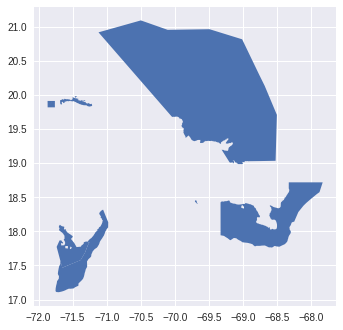

In [0]:
conserve.to_crs(epsg=4326).loc[conserve['MARINE'] == '2'][['MARINE','GIS_AREA','geometry']].plot()

Woohoo!

## Also before we move on...

**You can also perform call kinds of operations using the 'geometry' column (every GeoDataFrame has one).**
Above, we used the dataset's "GIS_AREA" attribute to run summary statistics. This is because the WDPA dataset uses its own methodology and decision factors for calculating polygon areas. Most datasets won't be this finicky.

The "geometry" column contains a Shapely geometry object (point, polygon, multi-point, multi-polygon, etc.) and is usually automatically detected when GeoPandas reads in your shapefile. But be careful! The geometry column won't always be called "geometry". Use the "name" method to double check. If GeoPandas chooses the wrong column for geometry, use the `set_geometry` method to specify which column to use.

In [0]:
# Call your geometry attribute and find its Shapely geometry type
conserve.geometry.head()

In [0]:
# Check which column GeoPandas has chosen as the "geometry" attribute
conserve.geometry.name

In [0]:
# Change if necessary (not necessary in our case, so this code is redundant)
conserve.set_geometry("geometry")
conserve.geometry.name

# Step 3: Prep your raster data

## Step 3.1 Read in your raster data: Numpy and OpticalRS

**Let's turn our attention to our raster data.** One of my favorite parts of Python is its ability to manipulate raster data. By turning a raster into an object called a NumPy array, you can directly access the matrix of values within raster pixels, analyzing and filtering raster data in [all kinds of ways](https://docs.scipy.org/doc/numpy/user/quickstart.html) within the expansive SciPy library. Arrays are also compatible with GeoPandas, so you don't have to worry about converting your vector data into SpatialPolygonsDataFrames (or whatever) to play well with rasters.

To turn our raster file into a numpy array, we'll use a library called OpticalRS by Jared Kibele found [here](https://github.com/jkibele/OpticalRS).

In [0]:
%pylab inline
from OpticalRS import *

Our first step is to read our raster file into OpticalRS. The `RasterDS()` function reads in a file and converts it into a raster-specific object called a 'Raster Dataset'. The `band_array` attribute of the 'Raster Dataset' is a NumPy array of your data.

In [0]:
# Loading my local files into Colaboratory
from google.colab import files
uploaded = files.upload()

In [0]:
# Define your GeoTiff filepath
bathy_dr_fp = "bathy_caribb_4326.tif"
        
# Turn your GeoTiff into a "Raster Dataset" object.
rds = RasterDS(bathy_dr_fp)

# Convert the "Raster Dataset" object into a numpy array
dominican_arr = rds.band_array

If you have lots of rasters to read in at once, define your root directory and run a loop through it
```
in_data_dir = "/home/carlson/tutorial_files/"
filenames = []
for p in os.listdir(in_data_dir):
    if p.endswith('.tif'):
        fp = os.path.join(in_data_dir, p)
        filenames.append(fp)
```

Let's check out the properties of our array and make sure the conversion worked

In [0]:
# Check array shape
dominican_arr.shape

In [0]:
# Find mean depth (pixel value) in your raster
dominican_arr.mean()

In [0]:
# Check size of array
dominican_arr.nbytes

In [0]:
# Create a quick plot
imshow(dominican_arr.squeeze(), cmap ='viridis')

Looks good!

### Exercise 3.1

In [0]:
# Follow the steps to load in your raster data as a NumPy array.

In [0]:
# Find the max bathymetry value in your array (use NumPy documentation: https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.statistics.html)

# Step 4: Analyze bathymetry by MPA ("Zonal Statistics")

## Step 4.1 Apply bathymetry to one "zone"

Running statistics on our array/raster is easy, but not terribly meaningful because my bounding box is pretty arbitrary. We need to clip our raster to MPAs in order to assess the bathymetry values within our "zones" of interest.  This is called "zonal statistics" (aka "cookie cutter statistics").

![Dwayne the rock image](https://github.com/rrcarlson/Intro_python_geo/blob/master/images/the_rock.png?raw=1)

Let's start by clipping our "Raster Dataset" object to MPA geometries. This is easy in OpticalRS using the `geometry_subset()` function. `geometry_subset` takes a geometry object (like the 'geometry' attribute of a GeoDataFrame row) and uses it as a bounding box (box-ish) for our "Raster Dataset", returning a NumPy array.

Since `geometry_subset` takes just one geometry, we'll
1. Dissolve all parks designated as "Marine" into one geometry.
2. Use this geometry as the "cookie cutter" for our raster.

In [3]:
# Create one geometry for ALL marine protected areas (Remember: MPAs are coded as '1')
mpas_dissolved = conserve.dissolve(by='MARINE').loc['2']

# Clip your array to the shape of MPAs (dissolved)
mpa_array = rds.geometry_subset(mpas_dissolved.geometry)

# Plot the clipped array
imshow(mpa_array.squeeze())

NameError: ignored

Great! Now we have an array of bathymetry values clipped to MPA boundaries. We can use [any statistical methods](https://docs.scipy.org/doc/numpy-1.14.0/reference/index.html) available within NumPy on this array.

In [0]:
# Find the mean, min, max, and range of bathymetry values for MPAs.
[mpa_array.mean(), mpa_array.min(), mpa_array.max(), mpa_array.ptp()]

Let's tighten this up by placing these commands in this same function. **Note:** There are lots of preexisting functions for doing "Raster Stats" in Python and R, but they're prescriptive in the types of statistics they return. By converting your raster into an array, you can apply anything in the **NumPy** universe to your data!

In [1]:
# Define a function encompassing all of the commands above.
# Clip Raster Dataset to vector object g.
# Find mean, min, max, and range values of clipped numpy array.
# Fetch the MPA ID from "g" and place alongside summary statistics.
def stats_bathy(g, rds):
    mpa_arr = rds.geometry_subset(g.geometry)
    mean_bathy = mpa_arr.mean()
    min_bathy = mpa_arr.min()
    max_bathy = mpa_arr.max()
    range_bathy = mpa_arr.ptp()
    mpa_id = g['WDPA_PID']
    return mpa_id, mean_bathy, min_bathy, max_bathy, range_bathy

In [2]:
# Try the function on g = mpas_dissolved
stats_bathy(mpas_dissolved, rds)

NameError: ignored

### Exercise 4.1

In [0]:
# Follow the steps above to clip your raster data to MPA boundaries.

In [0]:
# Define a new function calculating the standard deviation and coefficient of variation of MPA geometries

## Step 4.2: Apply bathymetry to many "zones"

Now that our personal "Raster Stats" are bundled neatly in one function, we can iterate through multiple geometries, for example, each individual MPA (undissolved). The easiest way to do this is to use `apply`, which operates like `apply` in R. Our steps are:

* Create an anonymous function using `lambda` and run each geometry (row) in our DataFrame through that function. 
* `apply` basically **points each geometry in our DataFrame**  to fill `g` in `stats_bathy(g, rds)`

In [0]:
# Define a new function that uses 'lambda' to iterate stats_bathy through multiple DataFrame rows (MPA geometries).
def stats_bathy_multiple(dataframe, rds):
    series_mpas = dataframe.apply(lambda r: stats_bathy(r, rds), axis=1)
    return series_mpas

In [0]:
# Try out the function on our original 'mpa' GeoDataFrame
series_mpas = stats_bathy_multiple(mpa, rds)
series_mpas

We now have summary statistics for all MPAs in our `conserve` dataset!

## Extra steps

The data above isn't in the most usable format. Our function returns a series of tuples, with each tuple representing a different MPA geometry. 

If I want to get all of this back into a DataFrame, I can split each tuple into separate values (attributes). There are several ways to do this, but one easy method is `vstack()`, which splits *thing* into multiple *sub-things* and stacks them vertically to make an array. I can then insert this data into a DataFrame.

In [0]:
# Convert your series of tuples into a DataFrame using 'vstack'
dataframe_mpas = pd.DataFrame(np.vstack(series_mpas))
dataframe_mpas

In [0]:
# Rename the columns of your DataFrame
dataframe_mpas = dataframe_mpas.rename(columns = {0:'WDPA_PID', 1:'mean_bathy', 2: 'min_bathy', 3: 'max_bathy', 4: 'range_bathy'})
dataframe_mpas

I can then save this data back out to a CSV. Saving tabular data is as simple as:
* DataFrame = Pandas = `pd.read_csv()` = `pd.to_csv()`
* GeoDataFrame = DataFrame with geometry attribute = GeoPandas = `gpd.read_file()` = `gpd.to_file()`

In [0]:
# Save DataFrame to CSV
dataframe_mpas.to_csv("python_ecodatascience.csv")

# Step 5: Review

* **Use Pandas to manage and clean tabular data in a DataFrame**
    * Use `loc` and `iloc` to index/subset data in a DataFrame.
    * Remember to check `dtype` 
* **Use GeoPandas** to do the same for geodata
* **NumPy is useful for managing data in arrays**, particularly if your data has over 2 dimensions.
* A few tips for **iterating through DataFrames**:
    * There are a bunch of iterative tools in Python--we used `apply` to iterate through GeoDataFrame rows (geometries) using axis=1 (we could also iterate through columns using axis=0). Some other important iterative tools that we didn't discuss are [loops](https://www.digitalocean.com/community/tutorials/how-to-construct-for-loops-in-python-3) and [list comprehensions](https://www.datacamp.com/community/tutorials/python-list-comprehension).
* Data Structures in Python come in [many shapes and sizes](https://pandas.pydata.org/pandas-docs/stable/dsintro.html). Arrange your data (whatever it may be) in the structure of your choosing by 1) reading the filepath into the desired library like GeoPandas or, 2) using your data as an argument in a Data Constructor.